In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Prediction framework

offset: 200 (0.1 sec), window: 1000 (0.5 sec)

Based on `window` lobs of data, we predict the next `offset` lobs of data. For example, for `data[:1000]`, we predict `data[1200]`


Target:

Out target is a movement by `std / 2` (denominator is used for balancing the classes):

Classes:
```
-1    359966
 0    338596
 1    337128
```

#### Features

> As features, I took top 5 from all the features' selection methods

**1 Autocorrelation**

Lag: 50ms (100 lobs) & 100ms (200 lobs) (since we predict 100ms ahead)

New columns: `mid_price`

**2 Donchian Channels**

Period: 50ms (100 lobs) & 100ms (200 lobs)

Calculation:
* Highest high; Lowest low; (Highest high + Lowest low) / 2
* In `period` lobs

New columns: `high`, `low`

**3 Highest High**

**4 Center of Gravity Oscillator (COG)**

Calculation:
$\frac{M + r * M_{-k}}{M + M_{-k}}$

Where:
* $M$ - current price
* $M_{-k}$ - price `k` lobs ago
* $r$ - weight

Computed for `k = [25, 50, 100, 250, 500]` lobs \
With weights: `r = [0.5, 0.25, 0.1, 0.05, 0.01]`

**5 Heikin-Ashi**

Open, Close, High, Low calculation:
1. Sort lobs and trades by time
2. For each lob make a list of trades done before it but after the previous lob
3. Calculate Open, Close, High, Low for each lob

```
HeikinClose = (Ot + Ht + Lt + CLt)/4
HeikinOpen = (Ot−1 + CLt−1)/2
HeikinHigh = max(Ht, Ot−1, CLt−1)
HeikinLow = min(Lt, Ot−1, CLt−1)
```

New columns: `open`, `close`

**1 Logistic Regression—Local Spatial Ratio**

See `Logistic Regression Features` section

**2 Best LOB Level—Bid Side Volume**

The total volume of buy orders at the best bid price

**3 Second Best LOB Level—Ask Volume**

Obvious

**4 Price and Volume Derivation**

Price -- mid price of 3 best asks and bids \
Volume -- volume of the 3 best bid and ask levels

The feature is computed as an average difference over the last `window` lobs

**5 Best LOB Level—Ask Side**

Obvious

**1 Logistic Regression—Spatial Ratio**

See `Logistic Regression Features` section

**2 Cointegration—Boolean Vector**

Split `window` lobs into `window / 10` intervals \
Check for cointegration of each interval with the last one (i.e. `i` and `9` for `i` in `[0, 9]`) \
If cointegration is found, set the corresponding bit in the vector to `1`

**3 Cointegration—Test Statistics**

Numerical values of cointegration test statistics. Computed as in `Cointegration—Boolean Vector` feature

**4 Price and Volume Means**

Average price and average volume of the best 5 bid and ask levels

**5 Average Type Intensity**

Frequency (in Hz) of `buy` and `sell` trades over the window

**1 Logistic Regression—Spatial Ratio**

See `Logistic Regression Features` section

**2 Second Best LOB Level—Ask Volume**

Obvious

**3 Price & Volume derivation**

Already described

**4 Spread & Mid-Price**

Features:
* Last spread and mid-price
* Average spread and mid-price over the window

**5 Partial Autocorrelation for Log Returns**

* Compute log returns
* Compute partial autocorrelation over them with lag 100 lobs (50ms) and 200 lobs (100ms)

**1 Logistic Regression—Probability Estimation**

See `Logistic Regression Features` section

**2 Logistic Regression—Spatial Ratio**

See `Logistic Regression Features` section

**3 Bollinger Bands**

mu -- average of closing prices over the window \
sigma -- standard deviation of closing prices over the window

3 features: $$\mu \pm 2\sigma, \mu$$

**4 Alligator Teeth**

To be honest, this feature doesn't make any sense to me, so I'll skip it.

**5 Cointegration—Test Statistics**

Already described

**LogReg Features**

Idea: LogReg which takes into account last `k` lobs (e.g. `k = 10`) and takes from each lob the volume of the `r` best bid and ask levels (e.g. `r = 5`). Then, the model is trained on the `k * r * 2` features to predict the price movement (movement by `std / 2` or not; i.e. 2 classes). The model is trained on the last `window` lobs.

Local Spatial Ratio; Spatial Ratio; Probability Estimation

* Probability Estimation is just the output of the model on the last lobs
* (Local) Spatial Ratio is the ratio of bid coefficients to ask coefficients
    * Important: I didn't really find any good source of information (ChatGPT, Google)

Another idea: Train a LogReg model to predict movement over the whole window \
Here, use only probability estimation as a feature

#### Columns required for the features

1. Autocorrelation
    * mid_price
2. Donchian Channels


In [1]:
import os

root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'MD_data')

lob_path = os.path.join(data_dir, 'lob.csv')
trades_path = os.path.join(data_dir, 'trades.csv')

In [2]:
import pandas as pd

lob = pd.read_csv(lob_path)
trades = pd.read_csv(trades_path)

#### Data Analysis

In [3]:
lob.head(3)

,Unnamed: 0,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,0,1722470402038431,0.011044,121492.0,0.011043,103687.0,0.011044,4663.0,0.011043,36226.0,...,0.011040,147374.0,0.011047,666690.0,0.011040,69663.0,0.011047,1000463.0,0.011040,90028.0
1,1,1722470402305331,0.011044,121492.0,0.011043,100499.0,0.011044,4663.0,0.011043,36226.0,...,0.011040,147374.0,0.011047,666690.0,0.011040,69663.0,0.011047,1000463.0,0.011040,90028.0
2,2,1722470403485121,0.011041,60925.0,0.011041,747323.0,0.011041,59430.0,0.011040,337839.0,...,0.011038,27842.0,0.011045,173025.0,0.011038,77932.0,0.011045,162045.0,0.011038,2520.0


In [4]:
trades.head(3)

,Unnamed: 0,local_timestamp,side,price,amount
0,0,1722470400014926,sell,0.011043,734
1,1,1722470402982045,sell,0.011043,1633
2,2,1722470402982047,sell,0.011043,25445


In [5]:

# format: 1722470400014926
timestamp_series = pd.to_datetime(trades['local_timestamp'], unit='ns')
timestamp_diff = timestamp_series.diff()
print("Start time: ", timestamp_series.min())
print("End time: ", timestamp_series.max())
print("Duration: ", (timestamp_series.max() - timestamp_series.min()).total_seconds(), " seconds")

rate = 1 / timestamp_diff.mean().total_seconds()

print(f'Rate: {rate:.2f} Hz')

Start time:  1970-01-20 22:27:50.400014926
End time:  1970-01-20 22:36:28.799849954
Duration:  518.399835  seconds
Rate: 43478.26 Hz


I guess it'd be fine to predict 100ms in the future

In [6]:
n_offset = rate / 10 # 100ms

In [7]:
# let's look at lob time stamps

lob_timestamp = pd.to_datetime(lob['local_timestamp'], unit='ns')
lob_timestamp_diff = lob_timestamp.diff()

print("Start time: ", lob_timestamp.min())
print("End time: ", lob_timestamp.max())
print("Duration: ", (lob_timestamp.max() - lob_timestamp.min()).total_seconds(), " seconds")
lob_rate =  1 / lob_timestamp_diff.mean().total_seconds()
print(f'Lob rate: {lob_rate:.2f} Hz')

Start time:  1970-01-20 22:27:50.402038431
End time:  1970-01-20 22:36:28.799947411
Duration:  518.397908  seconds
Lob rate: 2000.00 Hz


In [8]:
n_offset = int(lob_rate / 10) # 100ms
n_window = int(lob_rate / 2) # 500ms
print(f'offset: {n_offset}, window: {n_window}')

offset: 200, window: 1000


In [9]:
# shift demonstration
series = pd.Series([1, 2, 3, 4, 5])
series.shift(1)

0    NaN
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64

In [10]:
# rolling demonstration with mean
series.rolling(window=3).mean()

0    NaN
1    NaN
2    2.0
3    3.0
4    4.0
dtype: float64

In [64]:
series = pd.Series([1, 2, 3, 4, 5])

series.shift(-2) - series.shift(-1)

0    1.0
1    1.0
2    1.0
3    NaN
4    NaN
dtype: float64

In [92]:
def get_std_and_target_diff(series, n_offset, n_window):
    std = series.shift(n_offset).rolling(window=n_window).std()
    target_diff = series.shift(-n_window + 1) - series.shift(-(n_offset + n_window - 1))
    std, target_diff = std.dropna(), target_diff.dropna()
    assert len(std) == len(target_diff), f'{len(std)} != {len(target_diff)}'
    std = std.reset_index(drop=True)
    target_diff = target_diff.reset_index(drop=True)
    return std, target_diff

def get_target_array(std, target_diff, std_denom):
    target_array = target_diff / std * std_denom
    target_array = target_array.apply(lambda x: -1 if x < -1 else 1 if x > 1 else 0)
    return target_array

mid_price = (lob['bids[0].price'] + lob['asks[0].price']) / 2

In [91]:


std_denom = 2
lob_target_array = get_target_array(lob_std, lob_target_diff, std_denom)
# show balance
lob_target_array.value_counts()

Std: (1035491,), target_diff: (1035491,)
Target array: (1035491,)


 1    354266
 0    350964
-1    330261
Name: count, dtype: int64

#### Data Split

Since I don't have enough time to submit the whole solution I'll take `n=45000` lobs for training and `n=5000` for testing. 

In [45]:
train_range = range(0, 45000)
test_range = range(45000, 50000)

def prepare_lob(lob, trades, range):
    lob_partial = lob.iloc[range].copy()
    lob_partial.sort_values('local_timestamp', inplace=True)

    lob_end = lob_partial.local_timestamp.iloc[-1]
    lob_start = lob_partial.local_timestamp.iloc[0]

    trade_partial = trades[(trades.local_timestamp >= lob_start) & (trades.local_timestamp <= lob_end)].copy()
    trade_partial.sort_values('local_timestamp', inplace=True)

    return lob_partial, trade_partial


lob_train, trade_train = prepare_lob(lob, trades, train_range)
lob_test, trade_test = prepare_lob(lob, trades, test_range)

#### Feature Playground

First of all, we need to add columns: `mid_price`, `high`, `low`, `open`, `close`

In [46]:
# convert to timestamp
lob['local_timestamp'] = pd.to_datetime(lob['local_timestamp'], unit='ns')
trades['local_timestamp'] = pd.to_datetime(trades['local_timestamp'], unit='ns')

# sort lob and trades by timestamp
lob = lob.sort_values('local_timestamp')
trades = trades.sort_values('local_timestamp')

In [47]:
# pandas shift demonstration

series = pd.Series([1, 2, 3, 4, 5])
series.shift(1)

0    NaN
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64

In [48]:
trades.head(3)

,Unnamed: 0,local_timestamp,side,price,amount
0,0,1970-01-20 22:27:50.400014926,sell,0.011043,734
1,1,1970-01-20 22:27:50.402982045,sell,0.011043,1633
2,2,1970-01-20 22:27:50.402982047,sell,0.011043,25445


In [49]:
# mid / high / low -- easy
def add_mid_high_low(lob):
    lob['mid'] = (lob['bids[0].price'] + lob['asks[0].price']) / 2
    lob['high'] = lob['asks[0].price']
    lob['low'] = lob['bids[0].price']
    return lob

lob_train = add_mid_high_low(lob_train)
lob_test = add_mid_high_low(lob_test)

#### Features & Target

`df_to_series(df).rolling(window=window_size).apply(series_to_features)`

Unfortunately, I didn't finish all the features I wanted to write. I didn't estimate the time required properly.

In [94]:
def get_target(lob, n_offset, n_window, std_denom):
    mid = lob['mid']
    std, target_diff = get_std_and_target_diff(mid, n_offset, n_window)
    target_array = get_target_array(std, target_diff, std_denom)
    return target_array

n_offset = 200
n_window = 1000
std_denom = 2

lob_target_train = get_target(lob_train, n_offset, n_window, std_denom)
lob_target_test = get_target(lob_test, n_offset, n_window, std_denom)

In [95]:
lob_target_train.shape, lob_target_test.shape

((43801,), (3801,))

In [99]:
# truncate lob_train and lob_test to ignore the last n_offset rows

lob_train_trun = lob_train.iloc[:-n_offset]
lob_test_trun = lob_test.iloc[:-n_offset]

In [107]:
from tqdm import tqdm
from extractors import AutocorrelationFeature, \
                    DonchianChannelsFeature, \
                    HighestHighFeature, \
                    COGFeature, \
                    HeikinAshiFeature, \
                    PriceVolumeDerivationFeature, \
                    BestLOBLevelFeature, \
                    CointegrationBooleanVectorFeature, \
                    PriceVolumeMeans, \
                    SpreadMidPriceFeature, \
                    LogRegEstimatorFeature

feature_extractors = [
    AutocorrelationFeature(),
    DonchianChannelsFeature(),
    HighestHighFeature(),
    COGFeature(),
    HeikinAshiFeature(),
    PriceVolumeDerivationFeature(),
    BestLOBLevelFeature(),
    CointegrationBooleanVectorFeature(),
    PriceVolumeMeans(),
    SpreadMidPriceFeature(),
    LogRegEstimatorFeature()
]

X_train = pd.DataFrame()
X_test = pd.DataFrame()
for extractor in tqdm(feature_extractors):
    print(f'Extracting features from {extractor.__class__.__name__}')
    
    X_train = pd.concat([X_train, extractor.extract(lob_train_trun, trade_train)], axis=1)
    X_test = pd.concat([X_test, extractor.extract(lob_test_trun, trade_test)], axis=1)

  0%|          | 0/11 [00:00<?, ?it/s]

Extracting features from AutocorrelationFeature


  9%|▉         | 1/11 [04:00<40:04, 240.42s/it]

Extracting features from DonchianChannelsFeature


 18%|█▊        | 2/11 [11:19<53:35, 357.24s/it]

Extracting features from HighestHighFeature


 27%|██▋       | 3/11 [13:08<32:29, 243.69s/it]

Extracting features from COGFeature


 36%|███▋      | 4/11 [1:00:16<2:27:28, 1264.05s/it]

Extracting features from HeikinAshiFeature


 45%|████▌     | 5/11 [1:13:17<1:48:59, 1089.89s/it]

Extracting features from PriceVolumeDerivationFeature


 55%|█████▍    | 6/11 [1:17:21<1:06:52, 802.43s/it] 

Extracting features from BestLOBLevelFeature


 64%|██████▎   | 7/11 [1:20:58<40:43, 610.97s/it]  

Extracting features from CointegrationBooleanVectorFeature


 73%|███████▎  | 8/11 [2:12:51<1:10:22, 1407.44s/it]

Extracting features from PriceVolumeMeans


 82%|████████▏ | 9/11 [2:16:50<34:44, 1042.17s/it]  

Extracting features from SpreadMidPriceFeature


 91%|█████████ | 10/11 [2:24:24<14:20, 860.47s/it]

Extracting features from LogRegEstimatorFeature


100%|██████████| 11/11 [2:31:39<00:00, 827.26s/it]


In [108]:
X_train.shape, X_test.shape

((43801, 50), (3801, 50))

In [109]:
y_train, y_test = lob_target_train, lob_target_test
y_train.shape, y_test.shape

((43801,), (3801,))

#### Training

In [110]:
# Random forest + LogReg
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [111]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# print report

RandomForestClassifier(random_state=0)

In [112]:
from sklearn.metrics import classification_report

print("test report")
y_pred_test = rf.predict(X_test)
print(classification_report(y_test, y_pred_test))

print("train report")
y_pred_train = rf.predict(X_train)
print(classification_report(y_train, y_pred_train))

test report
              precision    recall  f1-score   support

          -1       0.37      0.63      0.46      1011
           0       0.55      0.52      0.54      1553
           1       0.25      0.12      0.16      1237

    accuracy                           0.42      3801
   macro avg       0.39      0.42      0.39      3801
weighted avg       0.40      0.42      0.39      3801

train report
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     12807
           0       1.00      1.00      1.00     15944
           1       1.00      1.00      1.00     15050

    accuracy                           1.00     43801
   macro avg       1.00      1.00      1.00     43801
weighted avg       1.00      1.00      1.00     43801



<Axes: >

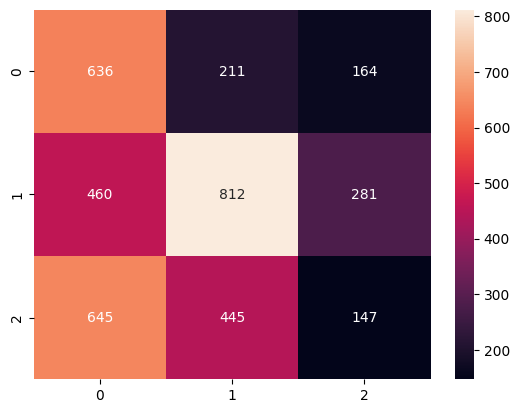

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')

In [114]:
# linear regression

lr = LogisticRegression(multi_class='ovr', max_iter=1000)
lr.fit(X_train, y_train)

print("test report")
y_pred_test = lr.predict(X_test)
print(classification_report(y_test, y_pred_test))

print("train report")
y_pred_train = lr.predict(X_train)
print(classification_report(y_train, y_pred_train))

c:\Users\rodio\Desktop\Programming\ML\market_forecasting\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


test report
              precision    recall  f1-score   support

          -1       0.39      0.20      0.26      1011
           0       0.43      0.90      0.58      1553
           1       0.40      0.02      0.03      1237

    accuracy                           0.43      3801
   macro avg       0.41      0.37      0.29      3801
weighted avg       0.41      0.43      0.32      3801

train report
              precision    recall  f1-score   support

          -1       0.32      0.08      0.12     12807
           0       0.36      0.87      0.51     15944
           1       0.26      0.05      0.08     15050

    accuracy                           0.35     43801
   macro avg       0.32      0.33      0.24     43801
weighted avg       0.32      0.35      0.25     43801

